In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_excel('/content/drive/My Drive/PTDLKD_IS403/processed_data/processed_data.xlsx')
df = pd.read_excel('processed_data2.xlsx')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=40,batch_size=64,verbose=1)

Epoch 1/40
23/23 [==============================] - 12s 236ms/step - loss: 0.0316 - val_loss: 0.0027
Epoch 2/40
23/23 [==============================] - 5s 240ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 3/40
23/23 [==============================] - 4s 181ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 4/40
23/23 [==============================] - 4s 175ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 5/40
23/23 [==============================] - 6s 245ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 6/40
23/23 [==============================] - 4s 176ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 7/40
23/23 [==============================] - 4s 174ms/step - loss: 0.0021 - val_loss: 9.7305e-04
Epoch 8/40
23/23 [==============================] - 6s 247ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/40
23/23 [==============================] - 5s 198ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/40
23/23 [==============================] - 4s 179ms/step - loss: 0.0017 - val_loss: 0

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 35ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [12]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
valid_rmse = np.sqrt(mean_squared_error(yval, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

# Calculate MSE
valid_mse = mean_squared_error(yval, y_pred_val)
test_mse = mean_squared_error(ytest, y_pred)

# Calculate MAE
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

# Calculate MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Validation RMSE: {valid_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Validation MSE: {valid_mse}")
print(f"Testing MSE: {test_mse}")
print(f"Validation MAE: {valid_mae}")
print(f"Testing MAE: {test_mae}")
print(f"Validation MAPE: {valid_mape}%")
print(f"Testing MAPE: {test_mape}%")

Validation RMSE: 2526.6889958645324
Testing RMSE: 1796.9220082566553
Validation MSE: 6384157.281822919
Testing MSE: 3228928.703757131
Validation MAE: 2507.837072113416
Testing MAE: 1776.4875114575789
Validation MAPE: 494842.36375431286%
Testing MAPE: 522829.3990035957%


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        # Ensure only the last 100 elements are used
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # Predict the next value
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        # Remove the first element to maintain the size of 100
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

# print(lst_output)

0 day input [0.4577646  0.45725262 0.46163151 0.46238539 0.45750124 0.44920908
 0.45427674 0.44978977 0.45502068 0.46301577 0.48117829 0.48764847
 0.49909749 0.51080124 0.49642633 0.52553618 0.52580258 0.52174382
 0.52435324 0.49478899 0.489578   0.50312763 0.51605766 0.49357727
 0.49533172 0.48829336 0.49310012 0.4839914  0.48954871 0.49824829
 0.51835694 0.51431624 0.50429358 0.50588171 0.49638101 0.53042805
 0.52322127 0.51238456 0.51039057 0.50794139 0.52432208 0.52513319
 0.49159479 0.5050671  0.50497674 0.49872967 0.494393   0.51986141
 0.52258806 0.57744175 0.58611463 0.56411573 0.57616896 0.55204372
 0.56108809 0.5787335  0.56501946 0.5508364  0.55603327 0.5514306
 0.54780661 0.51472775 0.49851266 0.49686566 0.49320109 0.5046421
 0.50480076 0.50233238 0.51616981 0.52251096 0.5081895  0.51310909
 0.51408314 0.51130903 0.50980816 0.51196803 0.52891657 0.54083236
 0.53994495 0.55557486 0.55874496 0.56021117 0.59501435 0.59133149
 0.62270663 0.63345111 0.62866856 0.62473415 0.64607

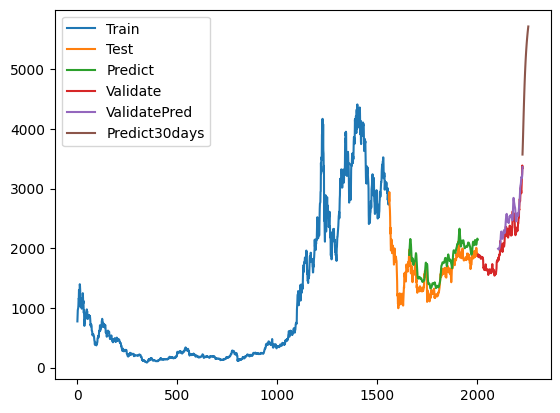

In [14]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()